# Modeling COVID-19 Spread and Healthcare Capacity # 

Goal is to predict how many COVID-19 patients they will have to provide in-patient medical care for in the next 3 weeks. This will be achieved by modelling the infection rate. Regions that will not have enough resources to cope with their COVID-19 patients in any given week will be matched to a region that will have a surplus of medical resources that week, so that the burden can be shared and more patients can receive life-saving treatment.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from operator import itemgetter
import operator

In [2]:
os.listdir("./")

['.DS_Store',
 'modeling_covics_eindhoven.ipynb',
 'figs',
 'code',
 '.gitmodules',
 'results',
 '.gitignore',
 '.ipynb_checkpoints',
 'modeling_covics.ipynb',
 'data']

In [ ]:
data_dir = "../../COVID-19/csse_covid_19_data/"

In [4]:
# Load datasets

covid_confirmed = pd.read_csv(data_dir+'csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_deaths = pd.read_csv(data_dir+'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_recovered = pd.read_csv(data_dir+'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [4]:
# Load the start of these datasets
#covid_confirmed.head()
#covid_deaths.head()
#covid_recovered.head()

In [5]:
# Extract all column names
cols_keys = covid_confirmed.keys()
# Make sure all datasets have the same columns
# Test this code with covid_confirmed = covid_confirmed.drop(['Lat'], axis=1)
lists = [covid_confirmed.keys(), covid_deaths.keys(), covid_recovered.keys()]
it = iter(lists)
the_len = len(cols_keys)
if not all(len(l) == the_len for l in it):
    raise ValueError('not all lists have same length!')

print(f'Total number of days in database: {len(cols_keys)}')

Total number of days in database: 71


In [6]:
# Collect the counts for each date
confirmed = covid_confirmed.loc[:, cols_keys[4]:cols_keys[-1]]
deaths = covid_deaths.loc[:, cols_keys[4]:cols_keys[-1]]
recovered = covid_recovered.loc[:, cols_keys[4]:cols_keys[-1]]
dates = confirmed.keys()

In [7]:
# Calculate totals, rates, and cumulative counts in the world
total_confirmed_global = []
total_deaths_global = []
total_recovered_global = []
mortality_rate_global = []
for d in dates:
    tmp_conf = confirmed[d].sum()
    tmp_deat = deaths[d].sum()
    tmp_reco = recovered[d].sum()
    total_confirmed_global.append(tmp_conf)
    total_deaths_global.append(tmp_deat)
    total_recovered_global.append(tmp_reco)
    mortality_rate_global.append(tmp_deat/tmp_conf)


In [8]:
# convert to numpy arrays
days = np.array([i for i in range(len(dates))]).reshape(-1,1)
total_confirmed_global = np.array(total_confirmed_global).reshape(-1,1)
total_deaths_global = np.array(total_deaths_global).reshape(-1,1)
total_recovered_global = np.array(total_recovered_global).reshape(-1,1)

In [9]:
# Exponential growth
def func(x, a, b):
    return a * np.exp(b * x) 
# Fit - but not working
#days2 = np.array([i for i in range(len(dates))]).reshape(1,-1)
#popt, pcov = curve_fit(func, days.ravel(),  total_confirmed.ravel())
#plt.plot(days, total_confirmed, 'b-', days, func(days, *popt), 'g--')
popt = [total_confirmed_global[0],0.1075]

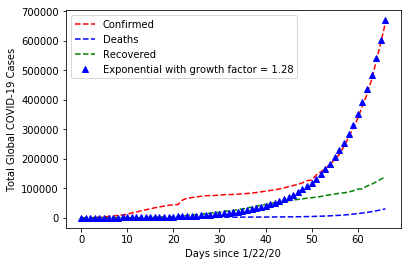

In [10]:
fig, ax = plt.subplots()
ax.plot(days, total_confirmed_global, 'r--', label='Confirmed')
ax.plot(days, total_deaths_global   , 'b--' , label='Deaths')
ax.plot(days, total_recovered_global, 'g--' , label='Recovered')
ax.plot(days, func(days, *popt), 'b^' , label='Exponential with growth factor = %.2f' % 10**popt[1])
plt.legend()
plt.xlabel('Days since %s' % dates[0])
plt.ylabel('Total Global COVID-19 Cases')
plt.show()

In [11]:
# Future forcasting for the next 3 weeks
# dates: actual dates
days_in_future = 21
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1) # days count including future forecasting
adjusted_dates = future_forecast[:-days_in_future] # days count up to now


In [12]:
# Convert all integers into datetime 
import datetime
start = '1/22/2020'
start_date = datetime.datetime.strptime(start,'%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [13]:
# Latest data
latest_confirmed = covid_confirmed[dates[-1]]
latest_deaths = covid_deaths[dates[-1]]
latest_recovered = covid_recovered[dates[-1]]

In [14]:
# List of unique countries
unique_countries = list(covid_recovered['Country/Region'].unique())

In [15]:
# Total number of cases by each country
total_confirmed_by_country = []
total_deaths_by_country = []
total_recovered_by_country = []
mortality_rate_by_country = []
no_cases = []

for i in unique_countries:
    cases_confirmed = latest_confirmed[covid_confirmed['Country/Region']==i].sum()
    cases_deaths = latest_deaths[covid_confirmed['Country/Region']==i].sum()
    cases_recovered = latest_recovered[covid_confirmed['Country/Region']==i].sum()
    #print(i, len(latest_confirmed[covid_confirmed['Country/Region']==i]))
    if cases_confirmed > 0:
        total_confirmed_by_country.append(cases_confirmed)
    else:
        no_cases.append(i)
    if cases_deaths > 0:
        total_deaths_by_country.append(cases_deaths)
    if cases_recovered > 0:
        total_recovered_by_country.append(cases_recovered)

for i in no_cases:
    unique_countries.remove(i)
# Sort based on the number of cases
unique_countries = [k for k,v in sorted(zip(unique_countries, total_confirmed_by_country), key=operator.itemgetter(1), reverse=True) ]
for i in range(len(unique_countries)):
    total_confirmed_by_country[i] = latest_confirmed[covid_confirmed['Country/Region']==unique_countries[i]].sum()

In [16]:
# Print number of cases per country/area
print('Confirmed cases by Countries/Regions')
for i in range(len(unique_countries[:10])):
    print(f'{unique_countries[i]}: {total_confirmed_by_country[i]} cases' )

Confirmed cases by Countries/Regions
US: 121478 cases
Italy: 92472 cases
China: 81999 cases
Spain: 73235 cases
Germany: 57695 cases
France: 38105 cases
Iran: 35408 cases
United Kingdom: 17312 cases
Switzerland: 14076 cases
Netherlands: 9819 cases


In [17]:
# List of unique province/state
unique_states = list(covid_recovered['Province/State'].unique())

In [18]:
# Total number of cases by each province/state
total_confirmed_by_state = []
no_cases = []
for i in unique_states:
    cases_confirmed = latest_confirmed[covid_confirmed['Province/State']==i].sum()
    if cases_confirmed > 0:
        total_confirmed_by_state.append(cases_confirmed)
    else:
        no_cases.append(i)

for i in no_cases:
    unique_states.remove(i)
    
# Print number of cases per country/area
print('Confirmed cases by Province/State')
for i in range(len(unique_states[:10])):
    print(f'{unique_states[i]}: {total_confirmed_by_state[i]} cases' )

Confirmed cases by Province/State
Australian Capital Territory: 71 cases
New South Wales: 1617 cases
Northern Territory: 15 cases
Queensland: 625 cases
South Australia: 287 cases
Tasmania: 62 cases
Victoria: 685 cases
Western Australia: 278 cases
Anhui: 990 cases
Beijing: 573 cases


In [19]:
# handle missing values
nan_indices = []

for i in range(len(unique_states)):
    if type(unique_states[i]) == float:
        nan_indices.append(i)

unique_states = list(unique_states)
total_confirmed_by_state = list(total_confirmed_by_state)

for i in nan_indices:
    unique_states.pop(i)
    total_confirmed_by_state.pop(i)

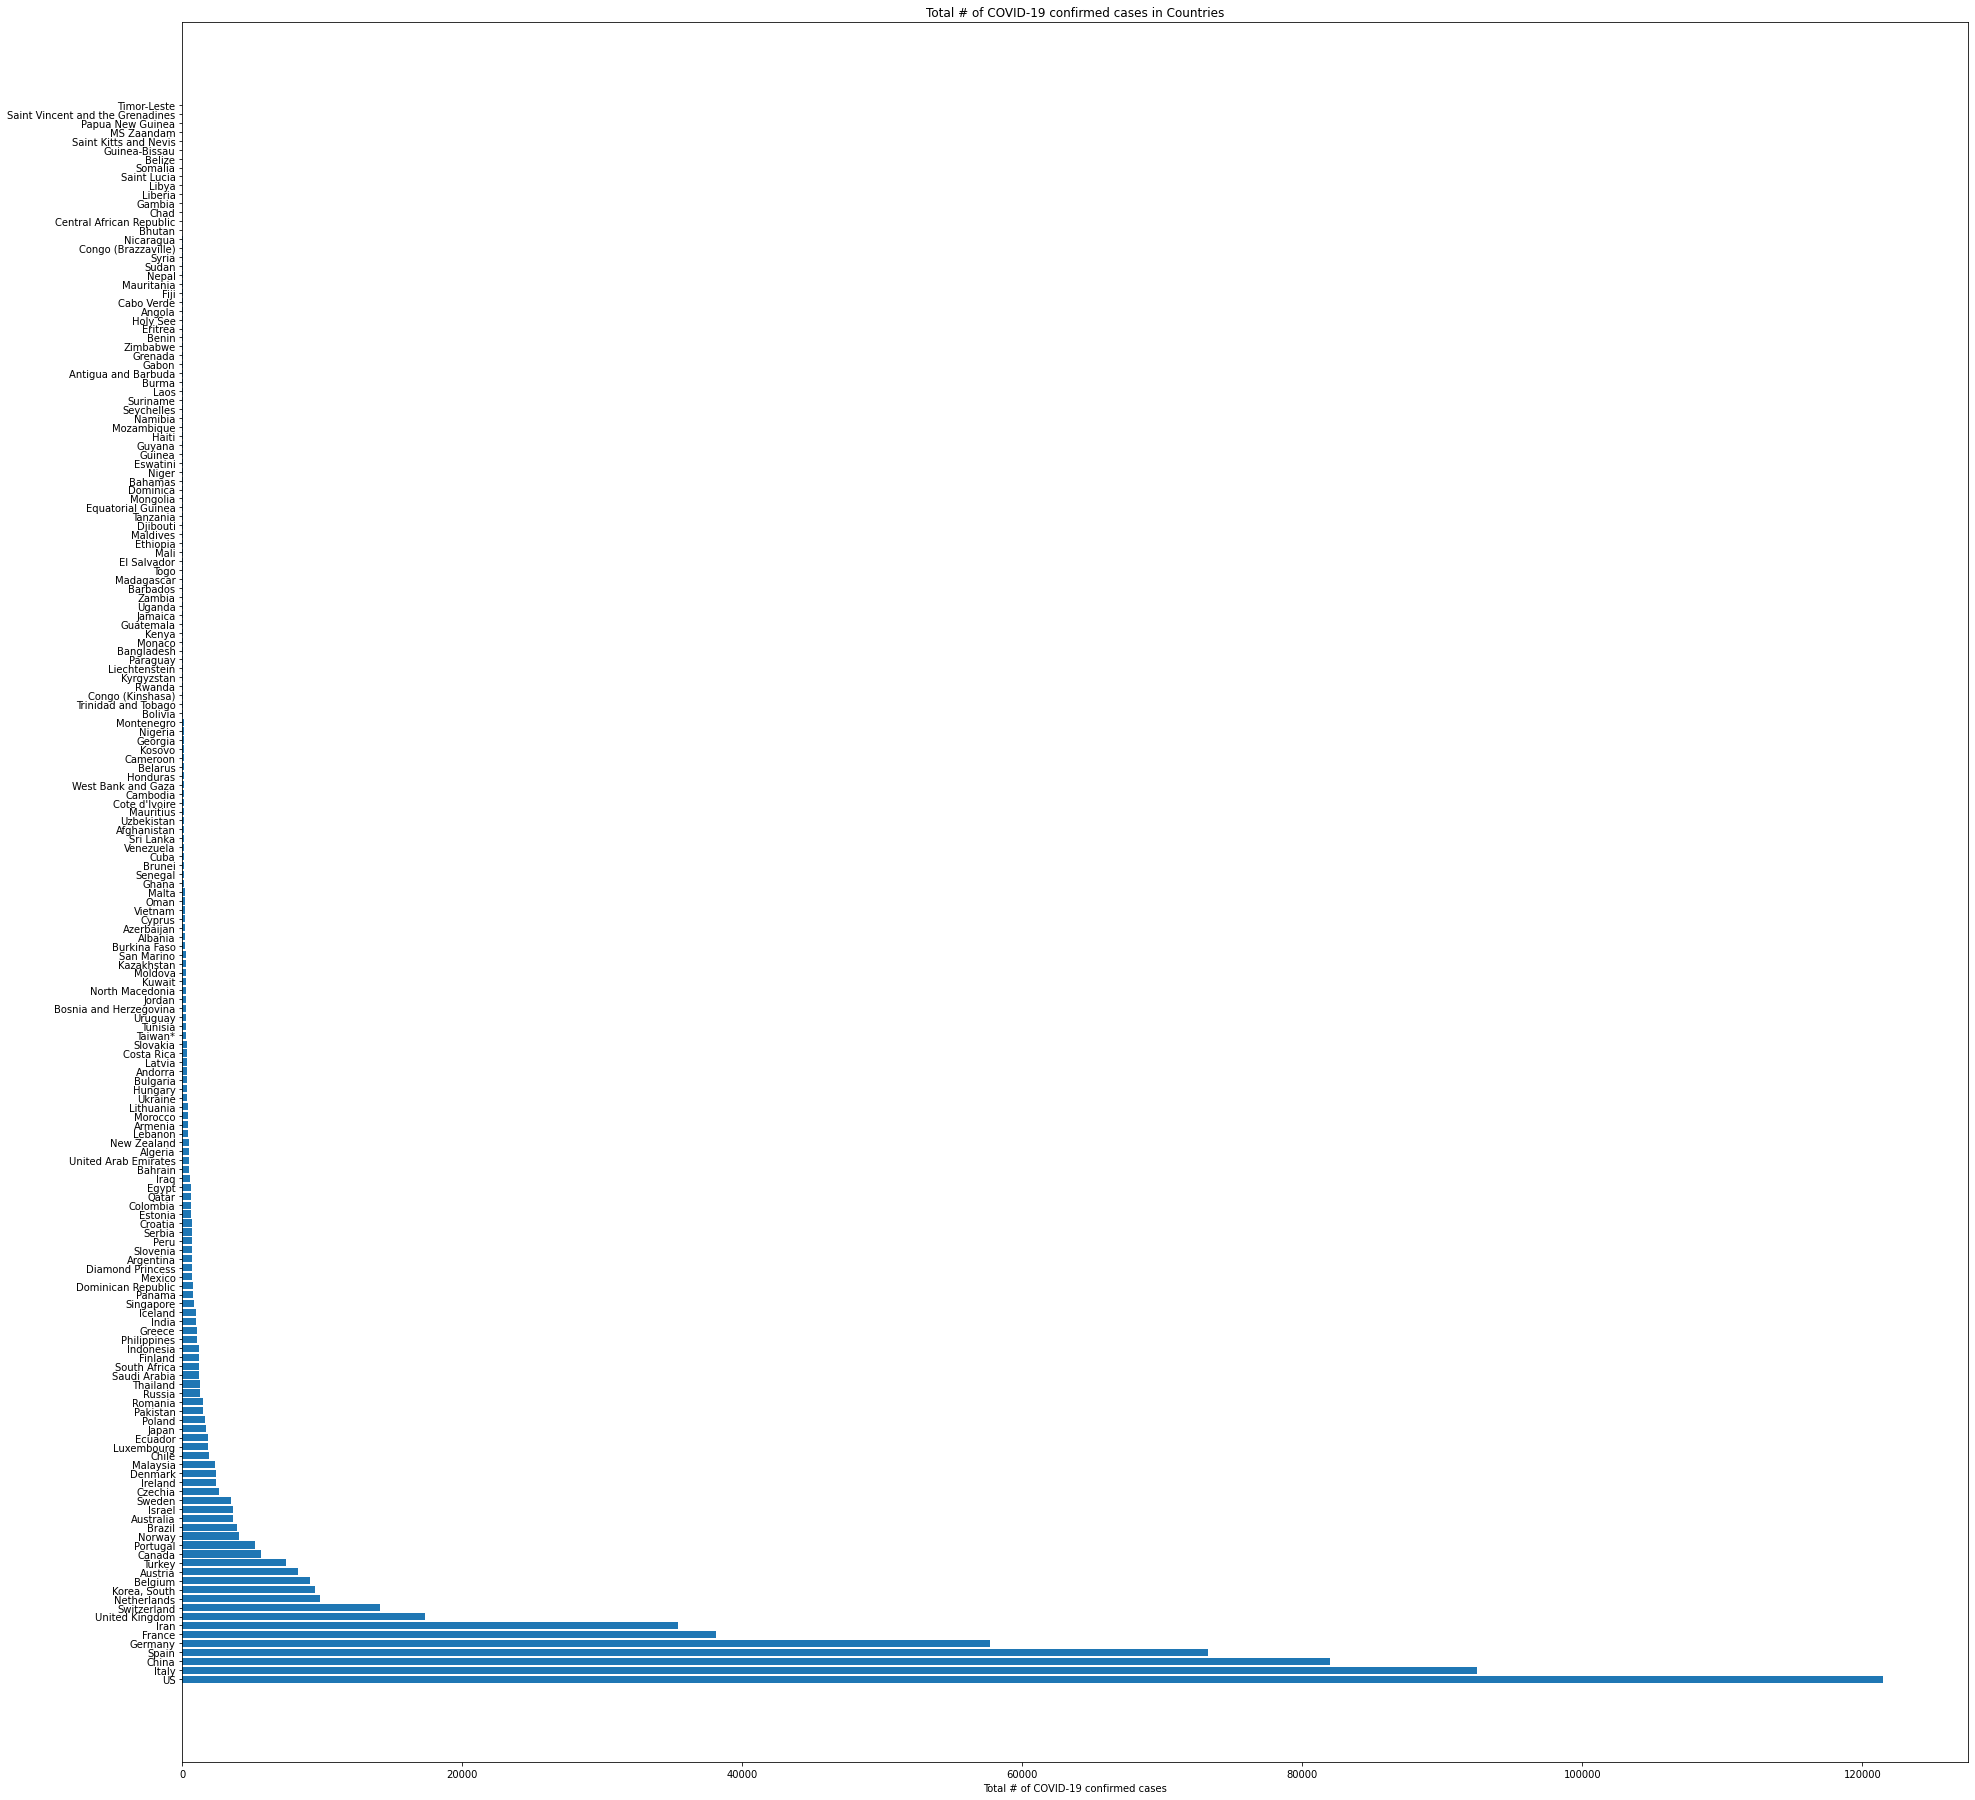

In [20]:
# Some visualization now

plt.figure(figsize=(32,32))
plt.barh(unique_countries, total_confirmed_by_country)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.xlabel("Total # of COVID-19 confirmed cases")
plt.show()

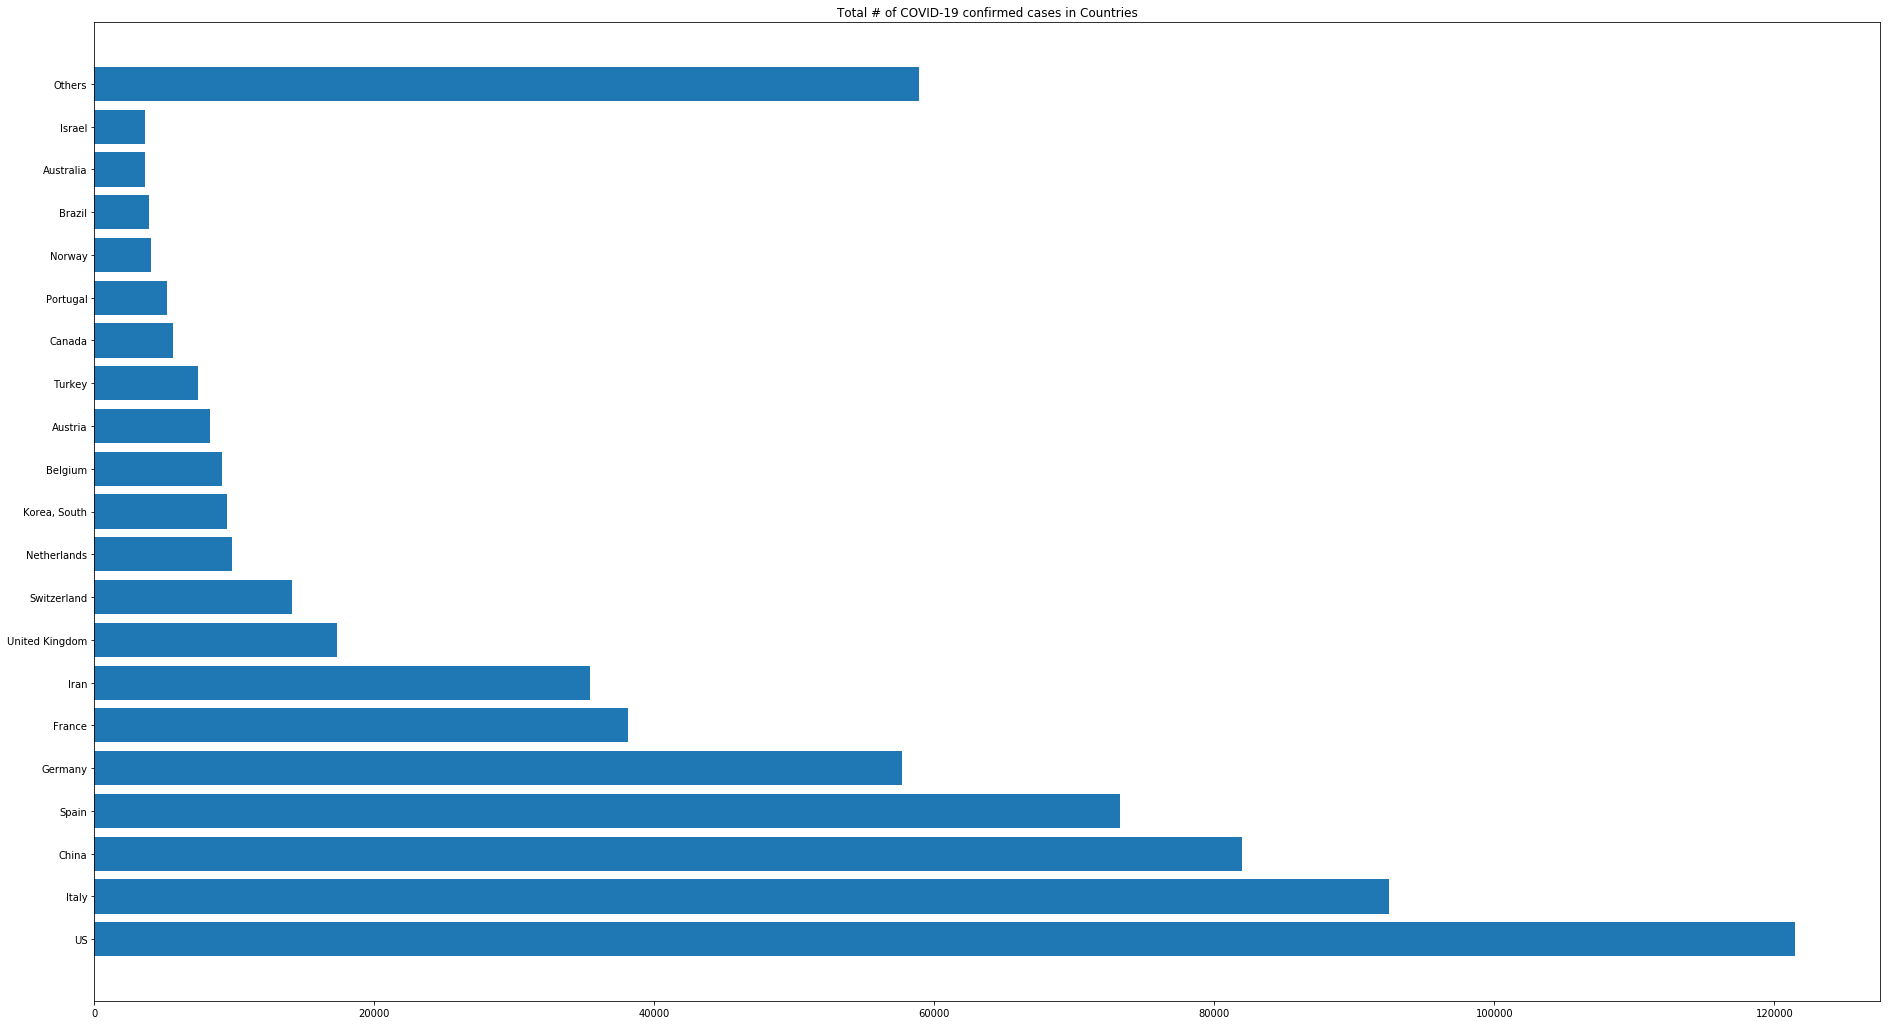

In [20]:
# make it easier to visualize, pick the 10 top cases + other cases
visual_unique_countries = []
visual_confirmed_cases = []
others = np.sum(total_confirmed_by_country[20:])
for i in range(len(total_confirmed_by_country[:20])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(total_confirmed_by_country[i])
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

plt.figure(figsize=(32,18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.show()

## Fit Hopkins data ## 

In [27]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed infections")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected infections (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected infections (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative Confirmed COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 121478
	Confirmed cases on 3/21/20 	 25489
	Ratio: 4.77
	Weekly increase: 376.6 %
	Daily increase: 25.0 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.9960704451922813
	Doubling Time (represents overall growth):  3.03 (± 0.1 ) days


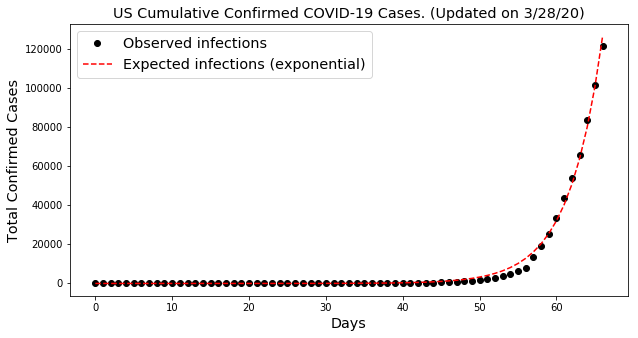



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 92472
	Confirmed cases on 3/21/20 	 53578
	Ratio: 1.73
	Weekly increase: 72.6 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9995732505421895
	Doubling Time (during middle of growth):  7.39 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.9822743660577621
	Doubling Time (represents overall growth):  5.68 (± 0.44 ) days


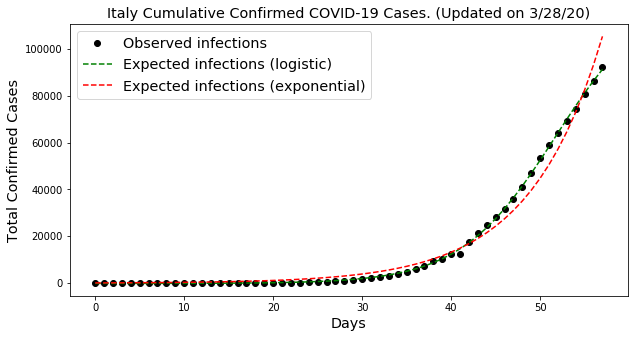



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 81999
	Confirmed cases on 3/21/20 	 81305
	Ratio: 1.01
	Weekly increase: 0.9 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 570.9 days

** Based on Logistic Fit**

	R^2: 0.9956956500454023
	Doubling Time (during middle of growth):  6.51 (± 0.49 ) days


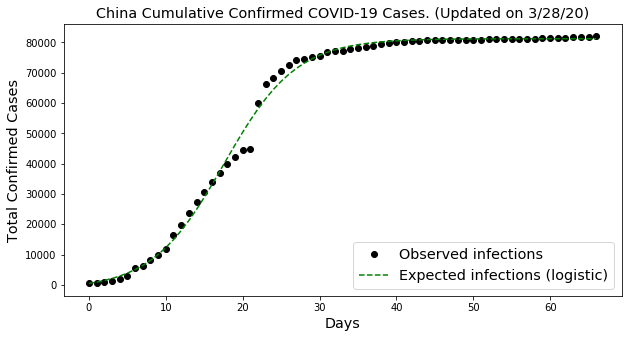



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 73235
	Confirmed cases on 3/21/20 	 25374
	Ratio: 2.89
	Weekly increase: 188.6 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9990232631098044
	Doubling Time (during middle of growth):  6.29 (± 0.3 ) days

** Based on Exponential Fit **

	R^2: 0.9955461602313334
	Doubling Time (represents overall growth):  4.13 (± 0.15 ) days


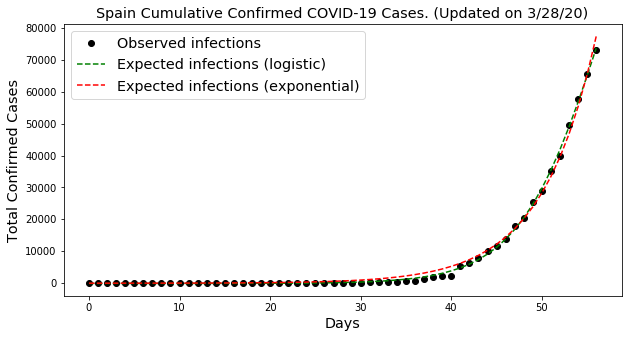



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 57695
	Confirmed cases on 3/21/20 	 22213
	Ratio: 2.6
	Weekly increase: 159.7 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9979502193618535
	Doubling Time (during middle of growth):  6.33 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.9935179667217177
	Doubling Time (represents overall growth):  4.35 (± 0.19 ) days


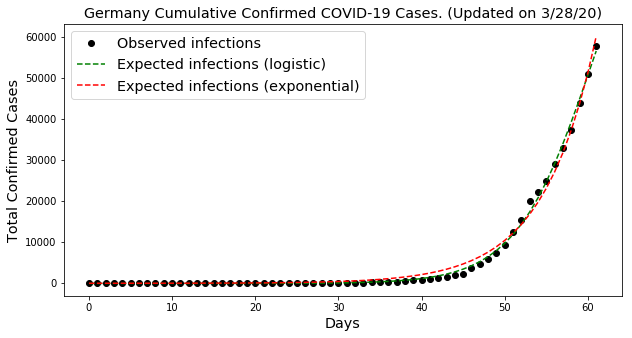

In [45]:
#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]

topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotCases(covid_confirmed, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3])
    print('\n')

    

## Prediction for the next 3 weeks ## 



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 121478
	Confirmed cases on 3/21/20 	 25489
	Ratio: 4.77
	Weekly increase: 376.6 %
	Daily increase: 25.0 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.9960704451922813
	Doubling Time (represents overall growth):  3.03 (± 0.1 ) days


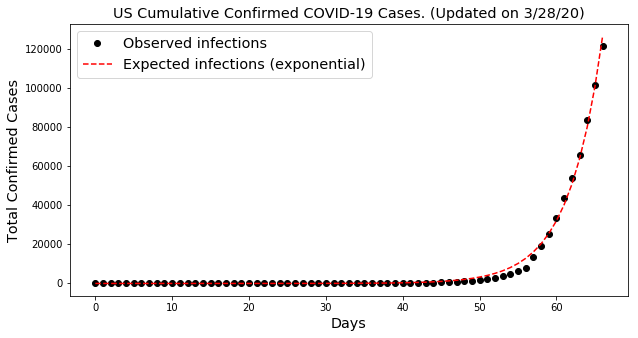

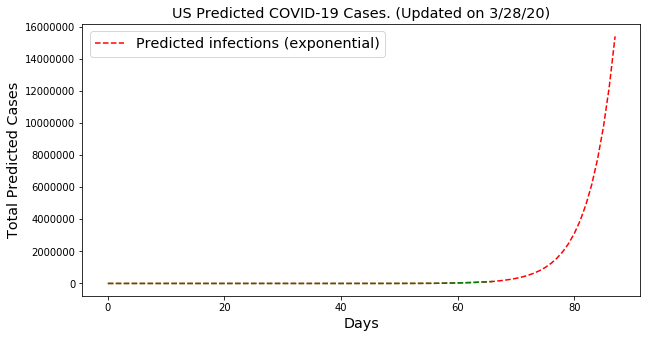



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 92472
	Confirmed cases on 3/21/20 	 53578
	Ratio: 1.73
	Weekly increase: 72.6 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9995732505421895
	Doubling Time (during middle of growth):  7.39 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.9822743660577621
	Doubling Time (represents overall growth):  5.68 (± 0.44 ) days


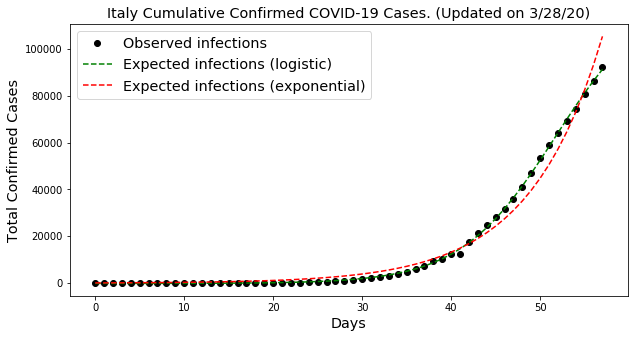

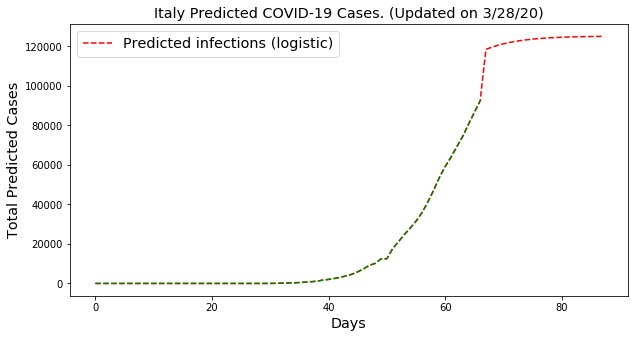



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 81999
	Confirmed cases on 3/21/20 	 81305
	Ratio: 1.01
	Weekly increase: 0.9 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 570.9 days

** Based on Logistic Fit**

	R^2: 0.9956956500454023
	Doubling Time (during middle of growth):  6.51 (± 0.49 ) days


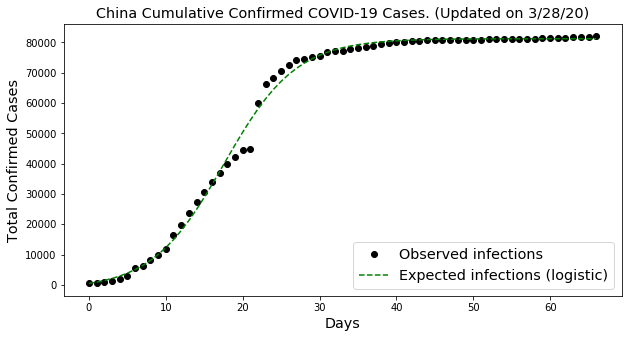

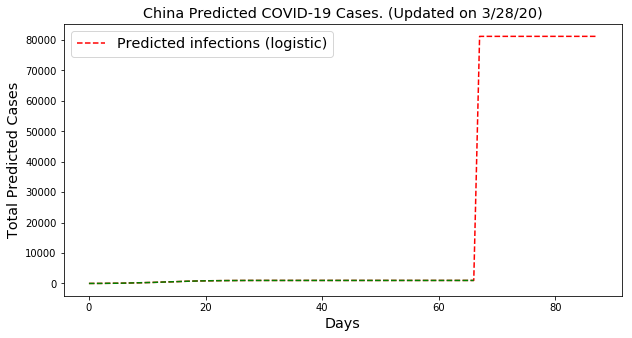



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 73235
	Confirmed cases on 3/21/20 	 25374
	Ratio: 2.89
	Weekly increase: 188.6 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9990232631098044
	Doubling Time (during middle of growth):  6.29 (± 0.3 ) days

** Based on Exponential Fit **

	R^2: 0.9955461602313334
	Doubling Time (represents overall growth):  4.13 (± 0.15 ) days


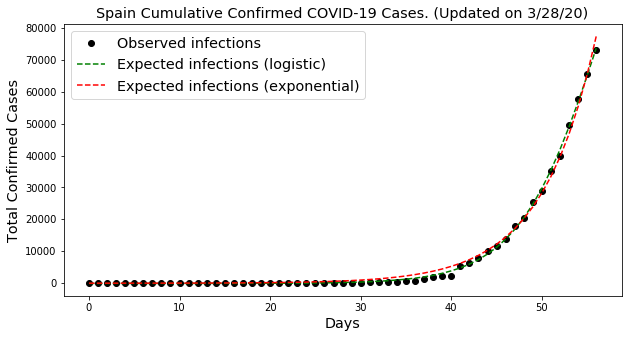

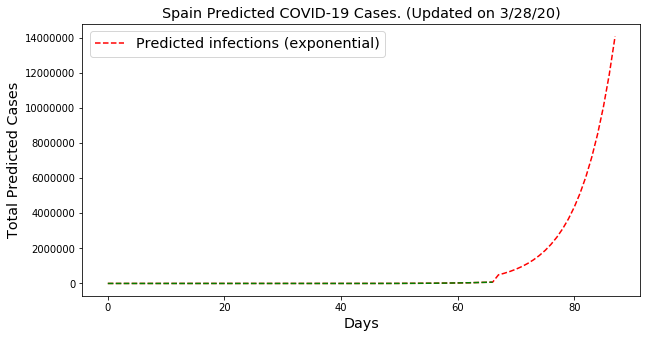



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 57695
	Confirmed cases on 3/21/20 	 22213
	Ratio: 2.6
	Weekly increase: 159.7 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9979502193618535
	Doubling Time (during middle of growth):  6.33 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.9935179667217177
	Doubling Time (represents overall growth):  4.35 (± 0.19 ) days


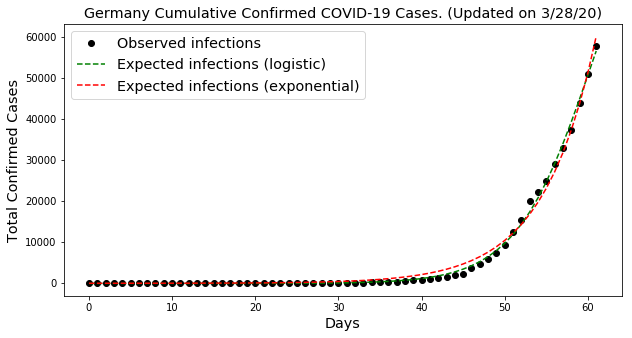

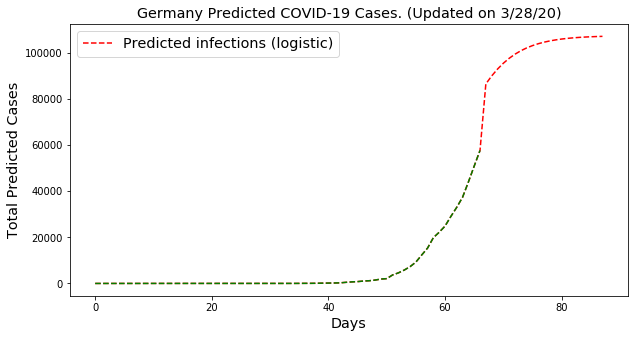

In [96]:
days = len(covid_confirmed.columns)-4 # how many days are in the data file (columns less the first 4)
days_to_model = days+(3*7) # 3 weeks + current number of days

#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]

topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')



for c in topcountries[:5]:
    print(c)
    a = plotCases(covid_confirmed, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3]) 
        plt.figure(figsize=(10,5))
        
        if(len(a[3])==3):
            preds = [exponential(t, a[3][0], a[3][1], a[3][2]) for t in list(range(days,days_to_model,1))] # do pred
            conf = covid_confirmed[covid_confirmed['Country/Region'] == c].iloc[:,4:].values[0].tolist() # get confirmed cases
            allc = conf+preds # append together
            x = list(range(0,days_to_model,1)) 
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted infections (exponential)") # plot predictions
            plt.plot(list(range(0,days,1)),conf,'g--') # plot confirmed cases in green
            
            
        if(len(a[3])==4):
            preds = [logistic(t, a[3][0], a[3][1], a[3][2],a[3][3]) for t in list(range(days,days_to_model,1))]
            conf = covid_confirmed[covid_confirmed['Country/Region'] == c].iloc[:,4:].values[0].tolist()
            allc = conf+preds
            x = list(range(0,days_to_model,1))
            y = allc
            plt.ticklabel_format(style = 'plain')
            plt.plot(x, y, 'r--', label="Predicted infections (logistic)")
            plt.plot(list(range(0,days,1)),conf,'g--')
            
    
    plt.title(c + ' Predicted COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Predicted Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    print('\n')

    
